In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import polars as pl
from pathlib import Path
from tqdm import tqdm

In [2]:

from adn.data import DatasetMode, load_datasets

individuals_snp_dir = Path("data/output/SNPs/")
metadata_path = Path("data/DIVRICE_3k10M_ch1/DIVRICE_3k10M_metadata.tsv")
sequence_length = 64
train_eval_split = 0
labels_to_remove = "cA"
individuals_to_ignore = Path("data/bad_guys.txt")

ds, _ = load_datasets(
    individuals_snp_dir=Path(individuals_snp_dir),
    metadata_path=Path(metadata_path),
    sequence_length=sequence_length,
    train_eval_split=train_eval_split,
    data_ratio_to_use=1,
    mode=DatasetMode.SEQUENTIAL_FIXED_LEN,
    labels_to_remove=labels_to_remove,
    individual_to_ignore=individuals_to_ignore,
    overlaping_ratio=0.5,
)

2025-03-20 20:28:39.771 | INFO     | adn.data:load_metadata:43 - Using labels: {'XI', 'GJ'}. Excluding: {'cA'}
2025-03-20 20:28:39.779 | INFO     | adn.data:load_metadata:52 - Ignoring individuals: {'IRIS_313-10054', 'IRIS_313-11656', 'IRIS_313-11808', 'IRIS_313-11807', 'B037', 'CX282', 'IRIS_313-9600', 'CX243', 'CX284', 'CX49,', 'IRIS_313-10158', 'IRIS_313-11286', 'IRIS_313-9841', 'IRIS_313-10300', 'IRIS_313-10318', 'IRIS_313-9817', 'CX11,', 'B176', 'IRIS_313-10771', 'B051', 'IRIS_313-9348', 'CX12,', 'IRIS_313-9400', 'IRIS_313-7725', 'IRIS_313-10998', 'B155', 'IRIS_313-10268', 'IRIS_313-11380', 'IRIS_313-9066,', 'B047', 'IRIS_313-11153', 'CX367'}
Loading SNP data...: 100%|██████████| 2617/2617 [00:02<00:00, 1044.59it/s]
2025-03-20 20:28:42.369 | INFO     | adn.data:load_datasets:103 - Train test split set to 0, using all data for training
2025-03-20 20:28:42.372 | INFO     | adn.data:load_datasets:142 - Train dataset loaded with 2617 individuals


In [ ]:
from adn.prediction import Predictor


predictor = Predictor(
    model_path=Path("output/v6-better-impl/checkpoints/checkpoint-13950")
)

predictor.predict_and_save(ds)

In [59]:
from adn.prediction_results import OnDiskPredictionResults


res = OnDiskPredictionResults(Path("output/v6-better-impl/predictions"), workers=8)
errors_df = res.compute_error()

Computing errors: 100%|██████████| 2616/2616 [00:11<00:00, 230.92file/s]


In [60]:
errors_df

,individual,logits,label,label_decoded,start_position,end_position,interval_length,GroupK9,pred,pred_prob,is_error,error,euclidean_distance_GJ,euclidean_distance_XI
0,IRIS_313-8660,"[0.85169864, 0.14830135]",1,XI,591382,1068713,477331,XI-2,0,0.851699,1,0.148301,9.053053,15.654326
1,IRIS_313-8660,"[0.5455751, 0.45442492]",1,XI,2790613,2832251,41638,XI-2,0,0.545575,1,0.454425,11.958268,11.918368
2,IRIS_313-8660,"[0.7660183, 0.23398171]",1,XI,4915492,5077628,162136,XI-2,0,0.766018,1,0.233982,8.917791,14.123564
3,IRIS_313-8660,"[0.92648864, 0.07351136]",1,XI,5047161,5096693,49532,XI-2,0,0.926489,1,0.073511,10.923420,16.104341
4,IRIS_313-8660,"[0.932894, 0.06710602]",1,XI,5077773,5104749,26976,XI-2,0,0.932894,1,0.067106,9.747943,16.700590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179062,CX380,"[0.1145317, 0.8854683]",0,GJ,41232672,41299556,66884,GJ-tmp,1,0.885468,1,0.114532,14.918256,9.223814
179063,CX380,"[0.47583088, 0.5241691]",0,GJ,41845080,41936408,91328,GJ-tmp,1,0.524169,1,0.475831,12.689550,12.031620
179064,CX380,"[0.1273191, 0.87268084]",0,GJ,41878476,42004552,126076,GJ-tmp,1,0.872681,1,0.127319,16.151619,9.023232
179065,CX380,"[0.24688815, 0.75311184]",0,GJ,42455504,42686352,230848,GJ-tmp,1,0.753112,1,0.246888,14.529854,9.636174


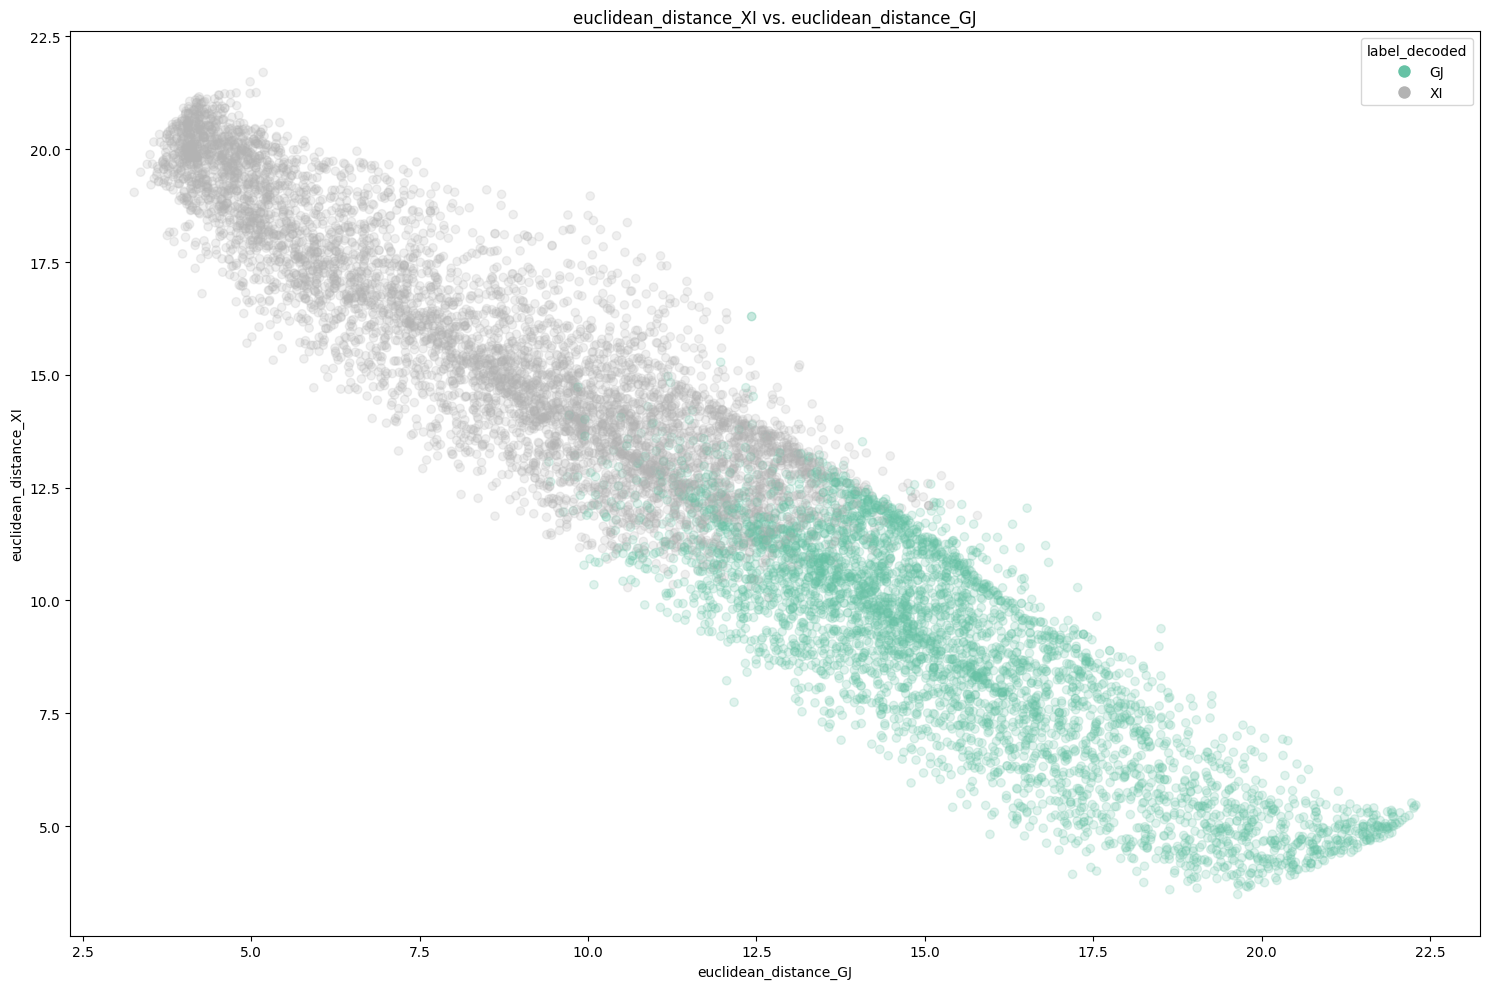

In [103]:
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib.colors import Colormap

def plot_euclidean_scatter(
    df: pd.DataFrame,
    sample_size: int = 10000,
    alpha: float = 0.2,
    cmap: Colormap = plt.cm.Set2
) -> None:
    sample = df.sample(min(sample_size, len(df)))

    label_col = "label_decoded"
    x_col = "euclidean_distance_GJ"
    y_col = "euclidean_distance_XI"
    
    label_categorical = pd.Categorical(sample[label_col])
    categories = label_categorical.categories
    codes = label_categorical.codes

    num_categories = len(categories)

    fig, ax = plt.subplots(figsize=(15, 10))

    ax.scatter(
        sample[x_col],
        sample[y_col],
        alpha=alpha,
        c=codes,
        cmap=cmap,
    )

    ax.set_title(f"{y_col} vs. {x_col}")
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)

    handles = [
        plt.Line2D(
            [], [], 
            marker="o", 
            color="w", 
            markerfacecolor=cmap(i / (num_categories - 1)),
            markersize=10, 
            label=cat
        )
        for i, cat in enumerate(categories)
    ]

    ax.legend(
        loc="best",
        handles=handles,
        title=label_col,
    )

    plt.tight_layout()
    plt.show()

plot_euclidean_scatter(
    errors_df,
    sample_size=10000,
)

In [91]:
label_categotial
    

['XI', 'XI', 'GJ', 'GJ', 'XI', ..., 'XI', 'XI', 'XI', 'GJ', 'XI']
Length: 10000
Categories (2, object): ['GJ', 'XI']

In [48]:
errors

,individual,logits,label,label_decoded,start_position,end_position,interval_length,GroupK9,pred,pred_prob,is_error,error,euclidean_distance_GJ,euclidean_distance_XI
32,IRIS_313-8660,"[0.85169864, 0.14830135]",1,XI,591382,1068713,477331,XI-2,0,0.851699,1,0.148301,9.053053,15.654326
67,IRIS_313-8660,"[0.5455751, 0.45442492]",1,XI,2790613,2832251,41638,XI-2,0,0.545575,1,0.454425,11.958268,11.918368
92,IRIS_313-8660,"[0.7660183, 0.23398171]",1,XI,4915492,5077628,162136,XI-2,0,0.766018,1,0.233982,8.917791,14.123564
93,IRIS_313-8660,"[0.92648864, 0.07351136]",1,XI,5047161,5096693,49532,XI-2,0,0.926489,1,0.073511,10.923420,16.104341
94,IRIS_313-8660,"[0.932894, 0.06710602]",1,XI,5077773,5104749,26976,XI-2,0,0.932894,1,0.067106,9.747943,16.700590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843,IRIS_313-8660,"[0.74496, 0.25504]",1,XI,43155724,43169832,14108,XI-2,0,0.744960,1,0.255040,9.791244,14.000529
844,IRIS_313-8660,"[0.71579427, 0.2842057]",1,XI,43159928,43177396,17468,XI-2,0,0.715794,1,0.284206,9.675002,13.749818
845,IRIS_313-8660,"[0.8116807, 0.18831925]",1,XI,43170168,43186104,15936,XI-2,0,0.811681,1,0.188319,8.862588,14.638370
846,IRIS_313-8660,"[0.7829274, 0.2170726]",1,XI,43177448,43215852,38404,XI-2,0,0.782927,1,0.217073,9.019714,14.416601


In [29]:
distances_df

,euclidean_distance_GJ,euclidean_distance_XI
individual,,
B001,"[11.83817897506343, 10.729180899369995, 13.407...","[13.943120115567941, 13.826184391444437, 11.54..."
B002,"[15.080450417580456, 16.837067829601803, 8.516...","[6.695242729851447, 5.456200245625445, 16.5945..."
B003,"[14.769141494691269, 10.977999395488556, 13.87...","[11.116515730479179, 14.50158706363529, 12.352..."
B004,"[15.637812059820789, 11.56225391787428, 6.6924...","[8.11110261414139, 12.667571381190035, 17.8186..."
B005,"[10.747734152823874, 13.571784748577496, 17.08...","[16.479886563882953, 9.878543887665895, 7.0771..."
...,...,...
IRIS_313-9980,"[11.731201139058774, 7.819529550849836, 7.4441...","[12.221825287079934, 15.405924686318992, 16.76..."
IRIS_313-9986,"[20.05541158013216, 18.808799065095872, 20.642...","[6.580027320366255, 5.958516210638397, 5.27012..."
IRIS_313-9989,"[14.099042921185104, 14.063371995742262, 20.87...","[9.402919030066169, 9.249578578726046, 4.77371..."


In [31]:
df["individual"]

individual
str
"""IRIS_313-8660"""
"""IRIS_313-8660"""
"""IRIS_313-8660"""
"""IRIS_313-8660"""
"""IRIS_313-8660"""
…
"""IRIS_313-8660"""
"""IRIS_313-8660"""
"""IRIS_313-8660"""


In [8]:
df

individual,logits,label,label_decoded,start_position,end_position,interval_length,GroupK9,pred,pred_prob,is_error,error
str,list[f32],i64,str,i64,i64,i64,str,i64,f32,i64,f64
"""IRIS_313-8660""","[0.032002, 0.967998]",1,"""XI""",1579,22288,20709,"""XI-2""",1,0.967998,0,0.0
"""IRIS_313-8660""","[0.019749, 0.980251]",1,"""XI""",10692,36138,25446,"""XI-2""",1,0.980251,0,0.0
"""IRIS_313-8660""","[0.028583, 0.971417]",1,"""XI""",22320,45081,22761,"""XI-2""",1,0.971417,0,0.0
"""IRIS_313-8660""","[0.030621, 0.969379]",1,"""XI""",36705,58951,22246,"""XI-2""",1,0.969379,0,0.0
"""IRIS_313-8660""","[0.034464, 0.965536]",1,"""XI""",45122,70612,25490,"""XI-2""",1,0.965536,0,0.0
…,…,…,…,…,…,…,…,…,…,…,…
"""IRIS_313-8660""","[0.74496, 0.25504]",1,"""XI""",43155724,43169832,14108,"""XI-2""",0,0.74496,1,0.25504
"""IRIS_313-8660""","[0.715794, 0.284206]",1,"""XI""",43159928,43177396,17468,"""XI-2""",0,0.715794,1,0.284206
"""IRIS_313-8660""","[0.811681, 0.188319]",1,"""XI""",43170168,43186104,15936,"""XI-2""",0,0.811681,1,0.188319
